In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.manifold import TSNE
import datetime
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import ward, fcluster
import plotly.graph_objects as go
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
#from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sh
from sklearn.metrics import adjusted_rand_score

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)

In [4]:
df_clean = pd.read_csv(r'C:\Users\pc\Documents\Projet4_Olis\Donnees\data_modelisation.csv')
df_clean.drop(["Unnamed: 0"], axis=1, inplace = True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114859 entries, 0 to 114858
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   review_id                      114859 non-null  object 
 1   order_id                       114859 non-null  object 
 2   review_score                   114859 non-null  int64  
 3   review_comment_title           13584 non-null   object 
 4   review_comment_message         48092 non-null   object 
 5   review_creation_date           114859 non-null  object 
 6   review_answer_timestamp        114859 non-null  object 
 7   order_item_id                  114859 non-null  float64
 8   product_id                     114859 non-null  object 
 9   seller_id                      114859 non-null  object 
 10  price                          114859 non-null  float64
 11  freight_value                  114859 non-null  float64
 12  customer_id                   

In [4]:
min_date = df_clean['order_purchase_timestamp'].min()
min_date = datetime.datetime.strptime(min_date, "%Y-%m-%d %H:%M:%S")

max_date = df_clean['order_purchase_timestamp'].max()
max_date = datetime.datetime.strptime(max_date, "%Y-%m-%d %H:%M:%S")

In [5]:
delta_date = (max_date - min_date).days
print("Nombre de jours entre la première et la dernière commande : {}".format(delta_date))

Nombre de jours entre la première et la dernière commande : 695


In [5]:
features = ['product_photos_qty', 'payment_installments', 'payment_value', 'review_score']

## Fonction pour calculer RFM

In [7]:
def features_calcul(data):
    date_max = data["order_purchase_timestamp"].max()
    date_max = datetime.datetime.strptime(date_max, "%Y-%m-%d %H:%M:%S")
    
    rfm = data.groupby('customer_unique_id').\
            agg({"order_purchase_timestamp": lambda x: x.max(),
                 "customer_unique_id": lambda x: len(x),
                 "payment_value": lambda x: sum(x),
                "review_score": lambda x: x.mean()})

    rfm['recency'] = rfm['order_purchase_timestamp'].apply(lambda x: (date_max - datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")).days)

    rfm.rename(columns={ 'customer_unique_id': 'frequency', 'payment_value': 'monetary_value'}, inplace=True)
    return rfm[["recency", "frequency", "monetary_value", "review_score"]]

In [8]:
############################################################################################

In [9]:
delta_old = 366
df_old = df_clean[df_clean['order_purchase_timestamp'] <= str(max_date - pd.Timedelta(days=delta_old))]
df_old.set_index(["customer_unique_id"], inplace = True)
df_old = df_old[['payment_value', 'review_score','order_purchase_timestamp']]
df_old.reset_index(inplace = True)
X_old = features_calcul(df_old)
X_old = StandardScaler().fit_transform(X_old)
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=4)
kmeans_old = kmeans.fit(X_old)

In [10]:
# On crée une liste vide pour stocker les valeurs de l'indice ARI :
ari_list = []
# On crée une liste vide pour stocker les dates :
days = []
step = 2
for i in range(int(delta_old/step)):

    # On récupère les données de notre dataset à partir de la date i :
    df_temp = df_clean[df_clean['order_purchase_timestamp'] <= str(max_date - pd.Timedelta(days=delta_old) + pd.Timedelta(days=i*step))]
    df_temp.set_index(["customer_unique_id"], inplace = True)
    df_temp = df_temp[['payment_value', 'review_score','order_purchase_timestamp']]
    df_temp.reset_index(inplace = True)
    X = features_calcul(df_temp)
    days.append(i*step)
    # On normalise les données :
    scale = StandardScaler()
    X_scaled = scale.fit_transform(X)

    # On effectue le clustering :
    kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
    kmeans.fit(X_scaled)
    # On calcule une prédiction sur les données :
    labels = kmeans.predict(X_scaled)
    labels_true = kmeans_old.predict(X_scaled)
    # On calcule l'indice ARI :
    ari_list.append(adjusted_rand_score(labels_true, labels))
    print("ARI for {} days old : {}".format(i*step, ari_list[-1]))

ARI for 0 days old : 0.9998345774772638
ARI for 2 days old : 0.986740461643658
ARI for 4 days old : 0.9942705208294493
ARI for 6 days old : 0.9907032181622889
ARI for 8 days old : 0.9653223330627526
ARI for 10 days old : 0.9599779873356745
ARI for 12 days old : 0.9524334632307447
ARI for 14 days old : 0.9442710689545847
ARI for 16 days old : 0.945588646716147
ARI for 18 days old : 0.9184872476481436
ARI for 20 days old : 0.9158714688331796
ARI for 22 days old : 0.9331668944452247
ARI for 24 days old : 0.9438431159272893
ARI for 26 days old : 0.9646400224141095
ARI for 28 days old : 0.9650984314371835
ARI for 30 days old : 0.9508230334733216
ARI for 32 days old : 0.9243344405490844
ARI for 34 days old : 0.8922411404691148
ARI for 36 days old : 0.8981930381199904
ARI for 38 days old : 0.9027913880148207
ARI for 40 days old : 0.8993329880774668
ARI for 42 days old : 0.8899195427973042
ARI for 44 days old : 0.8818815114164608
ARI for 46 days old : 0.882415027272835
ARI for 48 days old : 0.

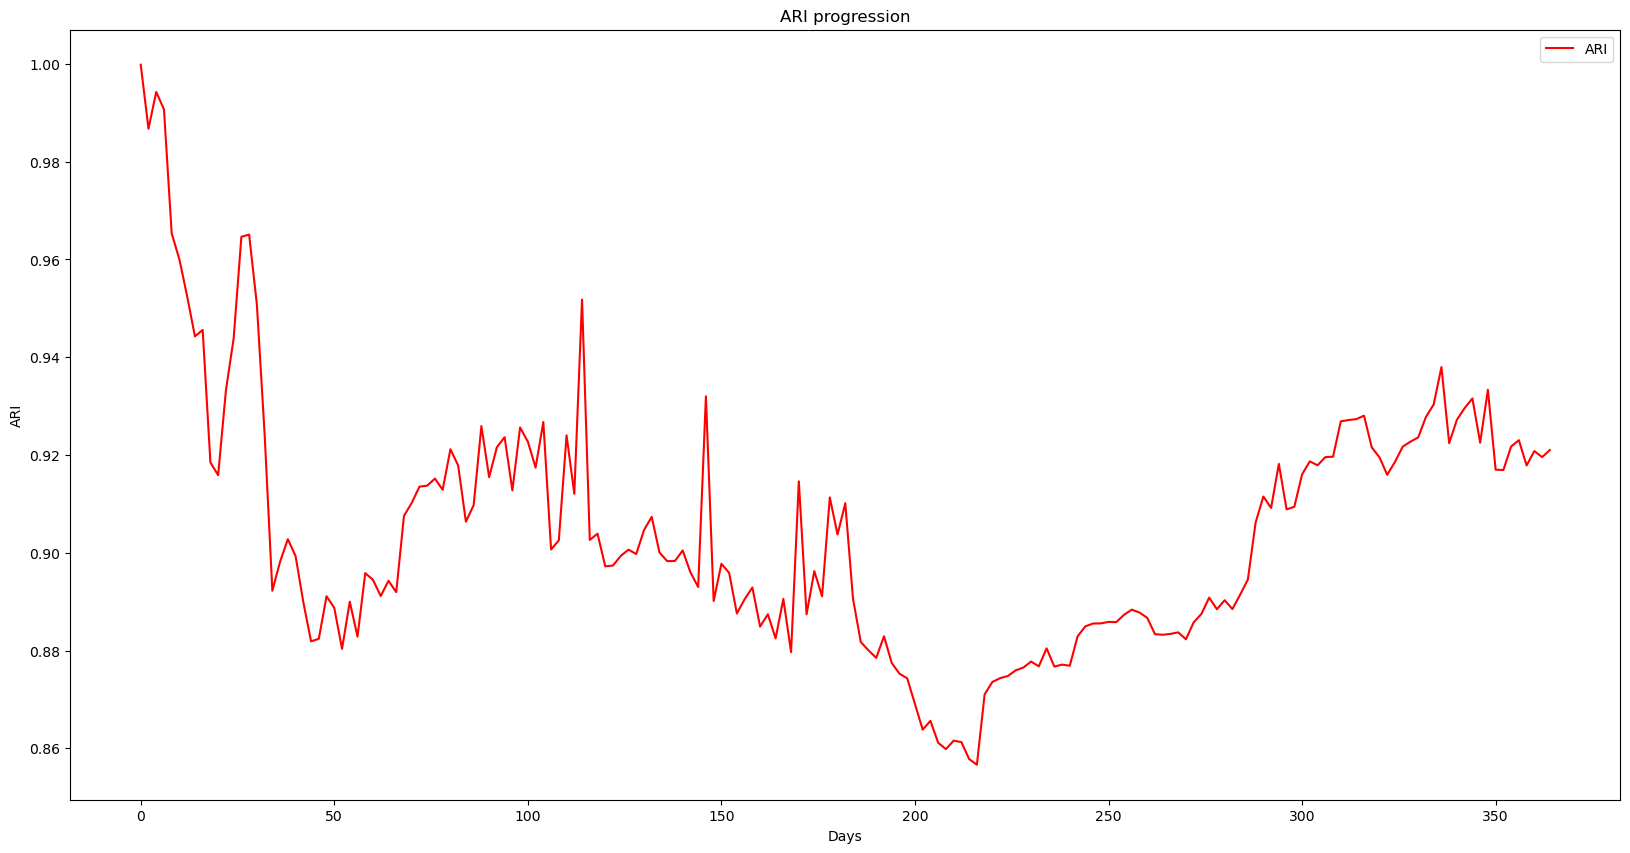

In [11]:
# On affiche le graphique :
plt.figure(figsize=(20,10))
sns.lineplot(x=days, y=ari_list, color='red', label='ARI')
plt.xlabel('Days')
plt.ylabel('ARI')
plt.title('ARI progression')
plt.show()

# STEP 17

# STEP 13

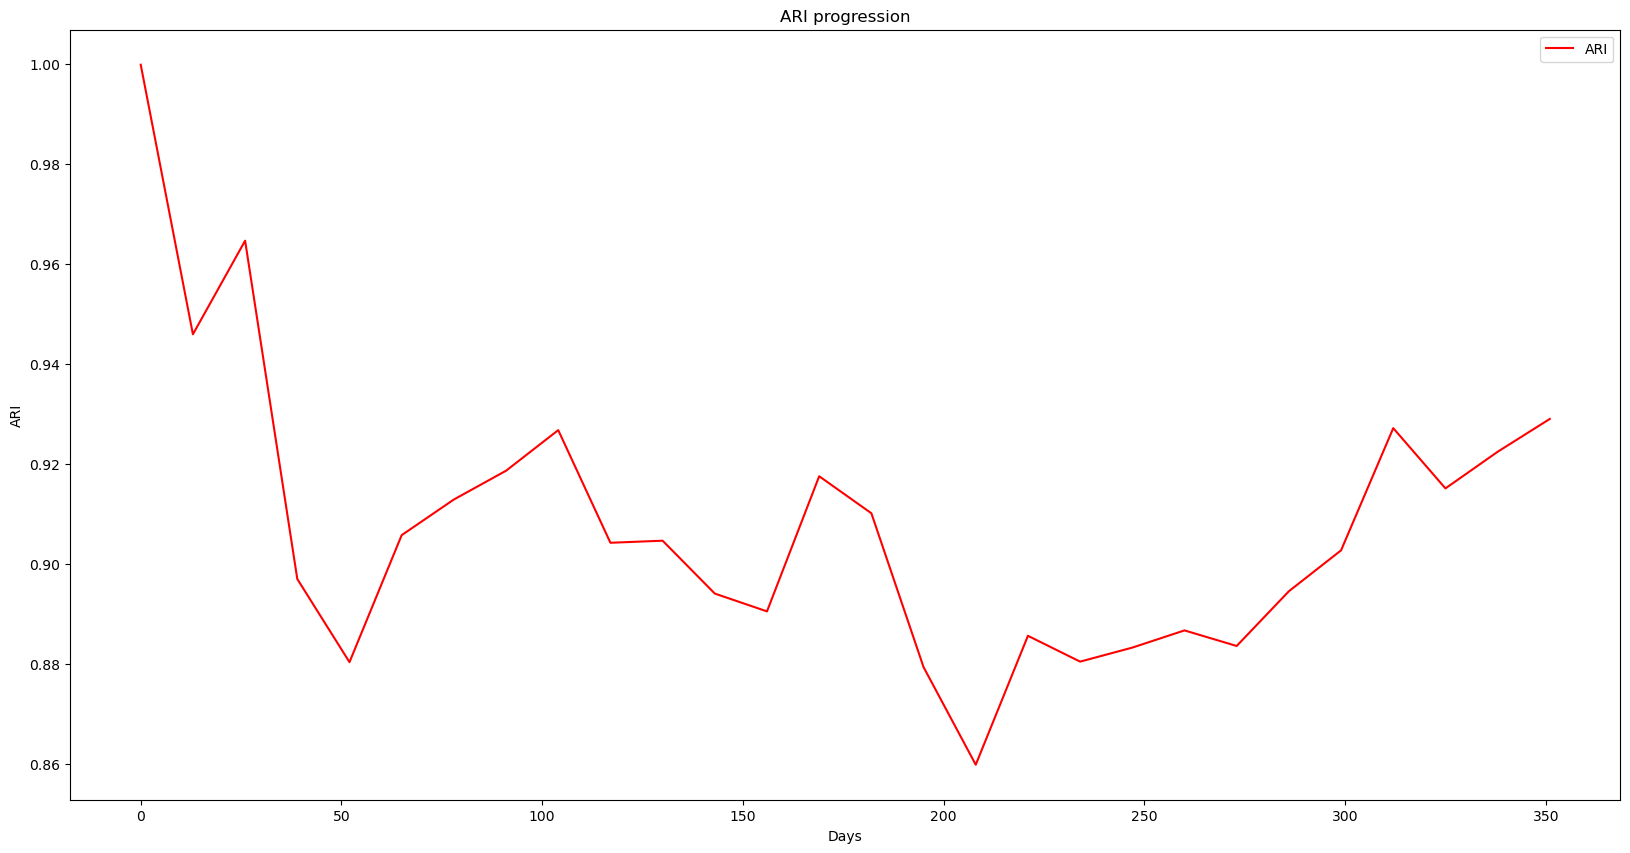

# STEP 10

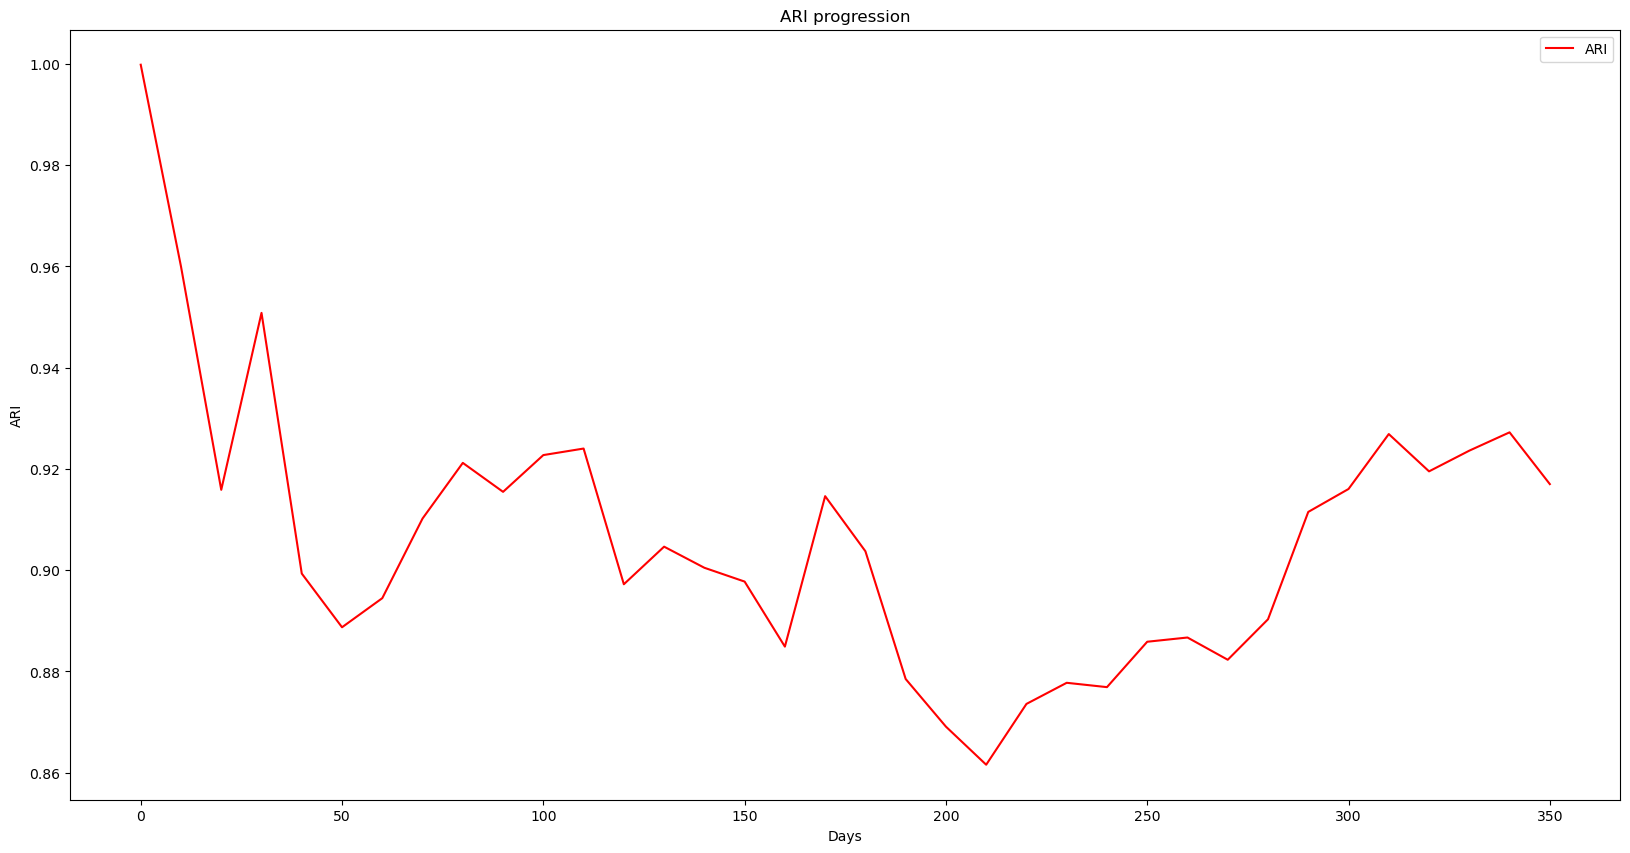

# STEP = 8

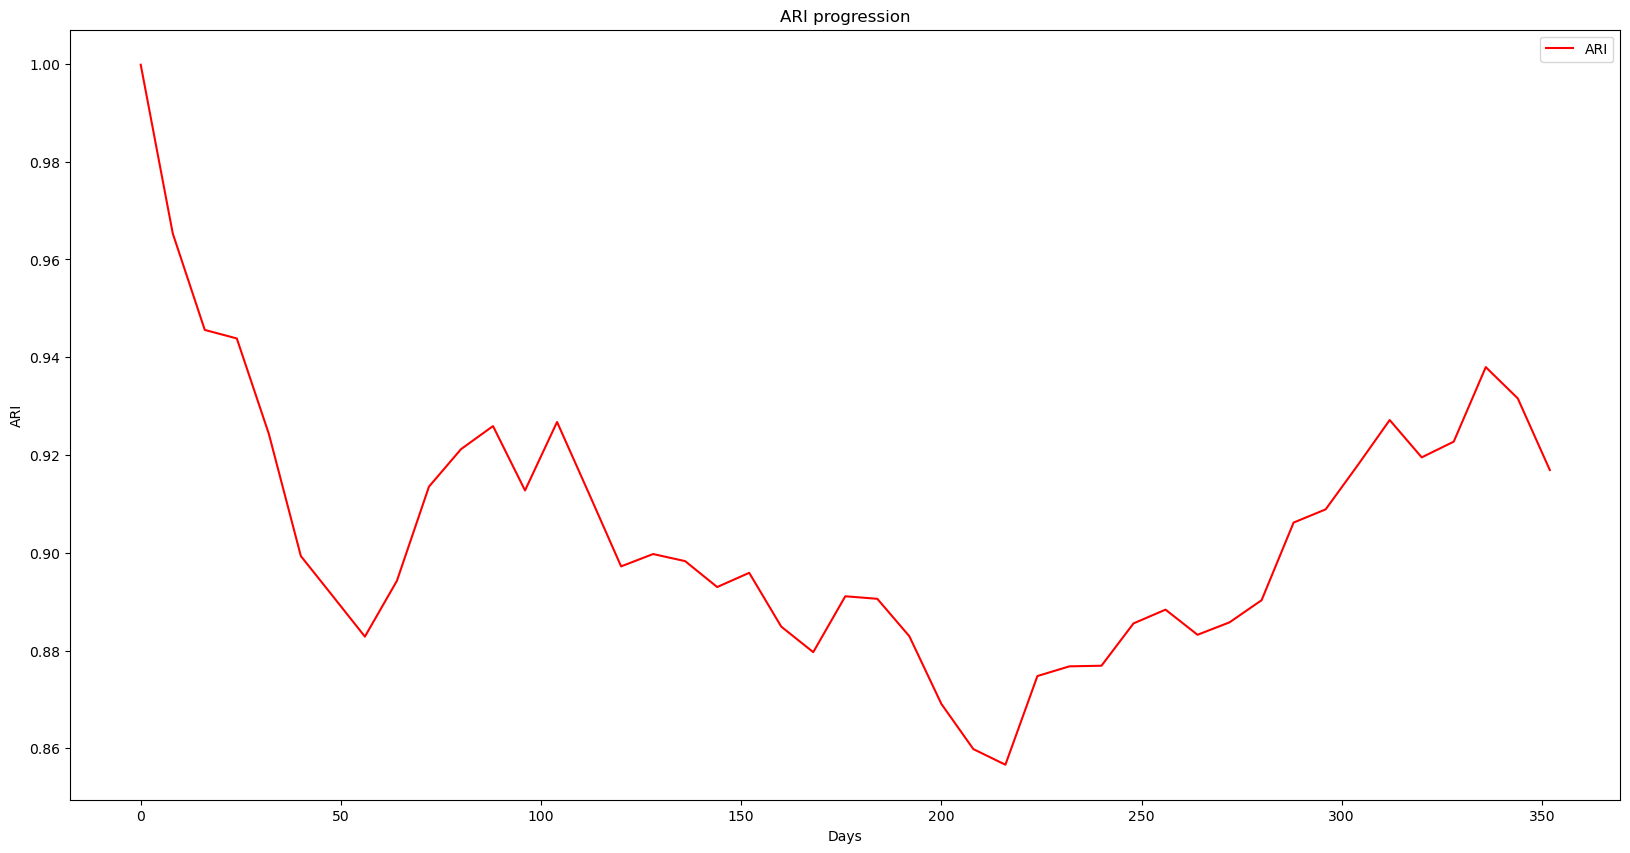

# STEP = 5

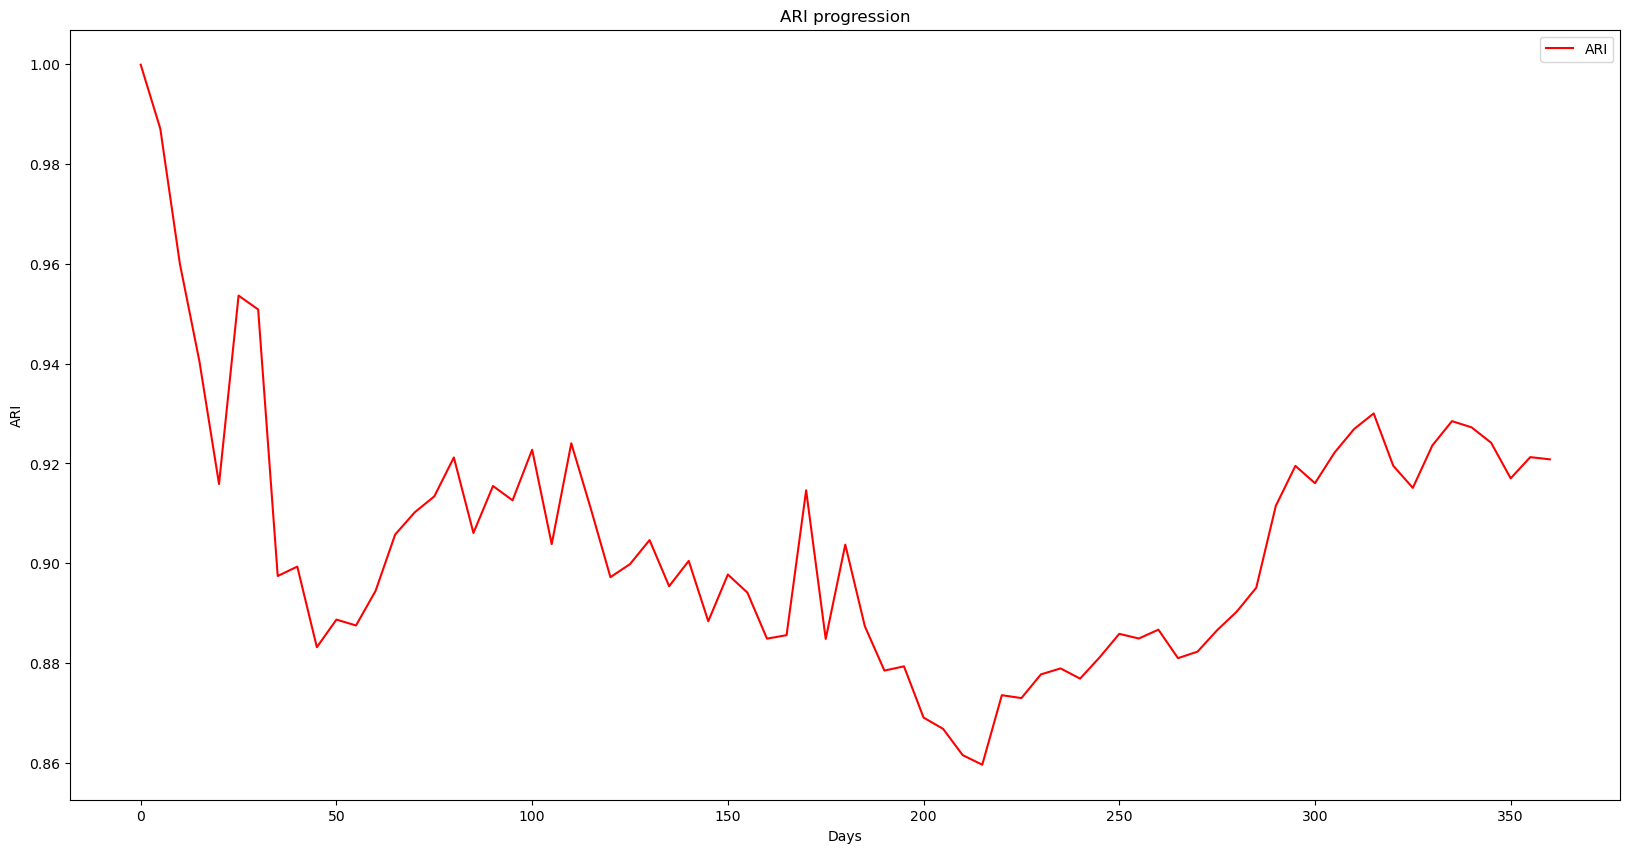

# STEP = 2

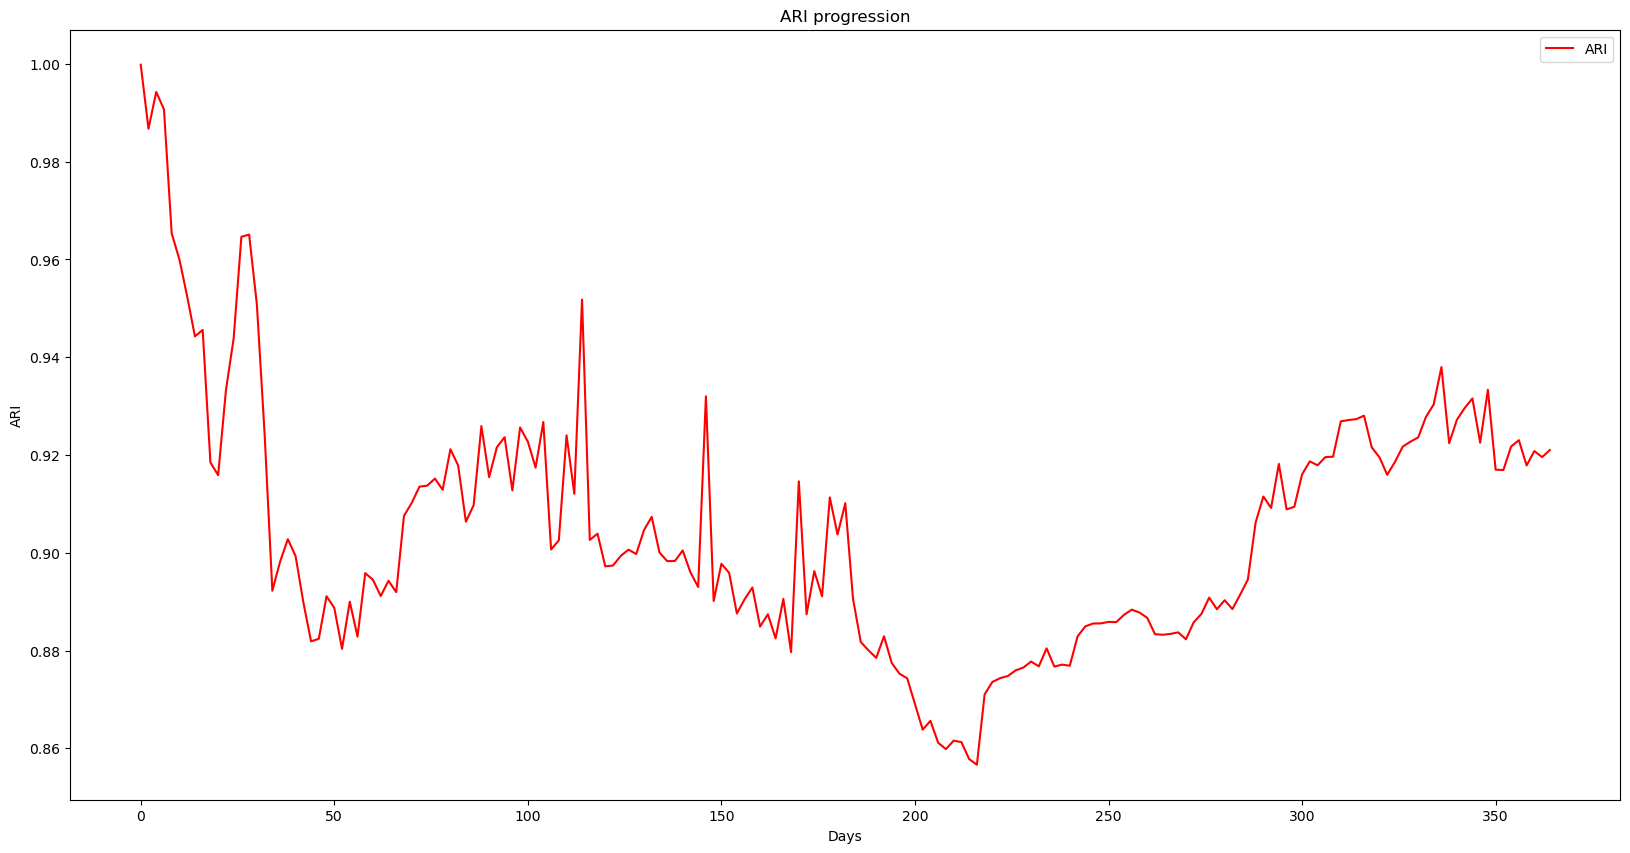

## STEP = 1

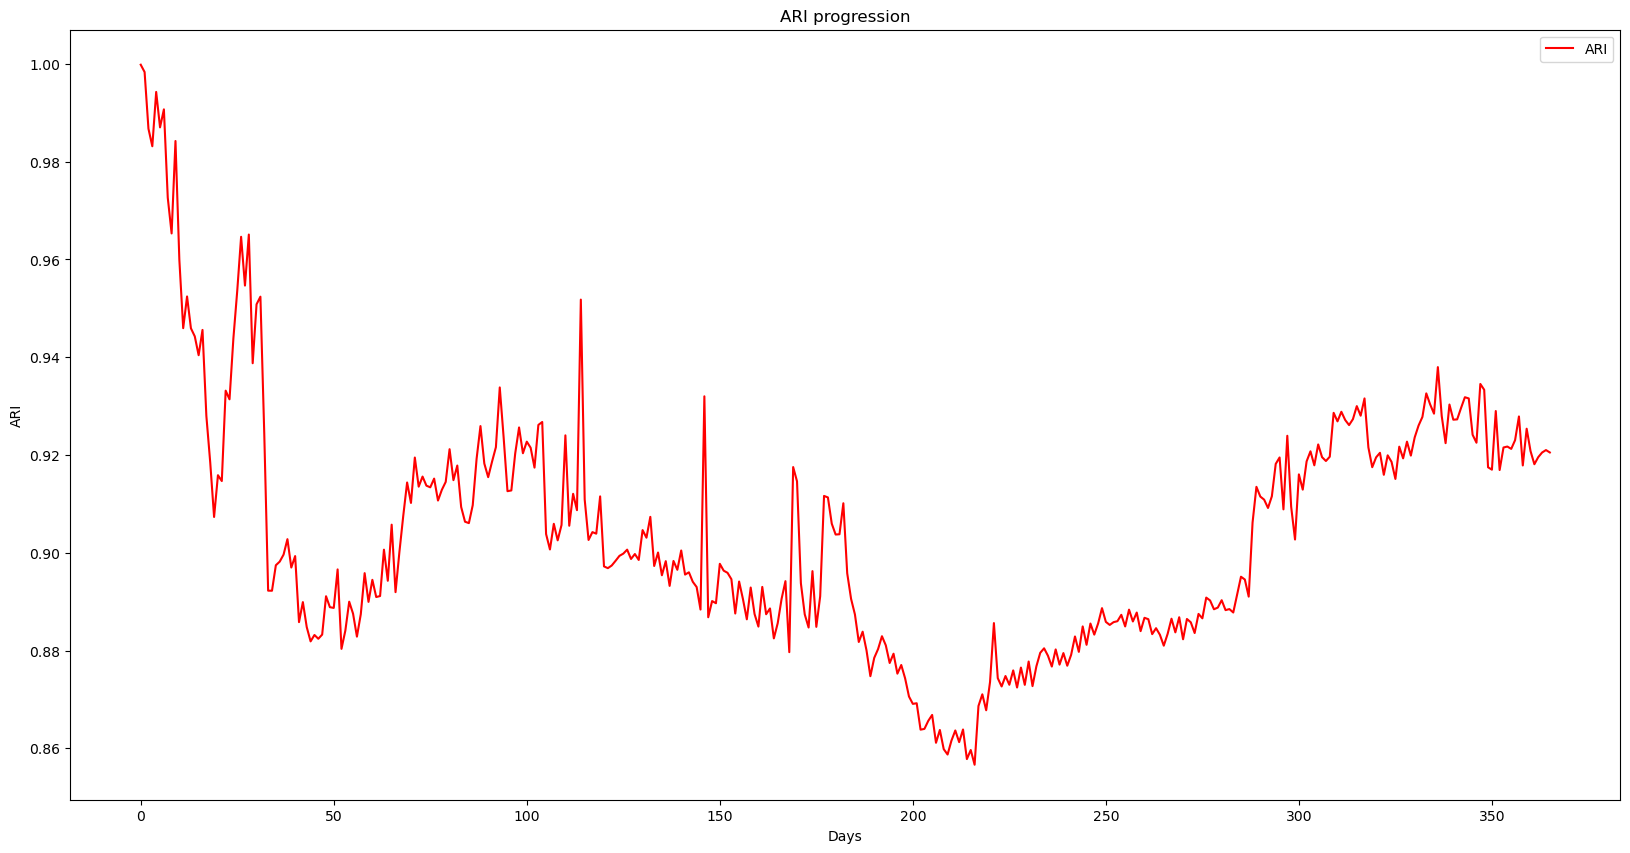